# 04-Model Training

_[Estimated execution time: 9 min]_

The toolkit allows to train the models while fixing some parameters, in this notebook we will show:

* Training of the model
* Training while keeping some parameters fixed
* Saving between trainings

In [1]:
import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Load dataset

For this tutorial we will use the Air quality dataset

The dataset hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device.

The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses.

We will only use 5 columns CO(GT), NMHC(GT), C6H6(GT), NOx(GT), NO2(GT)

For more info on data load check the tutorial [01 Data Loading](https://github.com/GAMES-UChile/mogptk/blob/master/examples/01_Data_Loading.ipynb).

For more info on data handling check the tutorial [02 Data Preparation](https://github.com/GAMES-UChile/mogptk/blob/master/examples/02_Data_Preparation.ipynb).

- For each sensor, the minimum value is -200, which is also de default value when there is an error in the measurements, so we will not take them into account by converting them to Nan. Note that the position of said values varies per channel, where the function [mogptk.LoadCSV](https://games-uchile.github.io/mogptk/dataset.html#mogptk.dataset.LoadCSV) automatically filters them.

- Then we will convert the dates to hours and use that as an input.

In [2]:
# load
df = pd.read_csv('data/AirQualityUCI.csv', delimiter=';')

cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# replace missing values with nan
df.replace(-200.0, np.nan, inplace=True)

# First 2 columns are date and time, we convert it to a single column with datetime format
df['Date'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# define a initial date to compare all other to
ini_date = pd.Timestamp('2004-03-10 00:00:00.0')

# get elapsed hours
df['Time'] = (df['Date'] - ini_date) / pd.Timedelta(hours=1)

# use only the first 8 days of data
df2 = df[df['Date'] < pd.Timestamp('2004-03-19 00:00:00.0')]

dataset = mogptk.LoadDataFrame(df2,
                    x_col='Time',
                    y_col=cols)

Remove aditional data to simulate sensor failure.

In this case for each channel we will first remove 40% of the observations and then remove complete sectors in order to get a reconstructions from the other channels

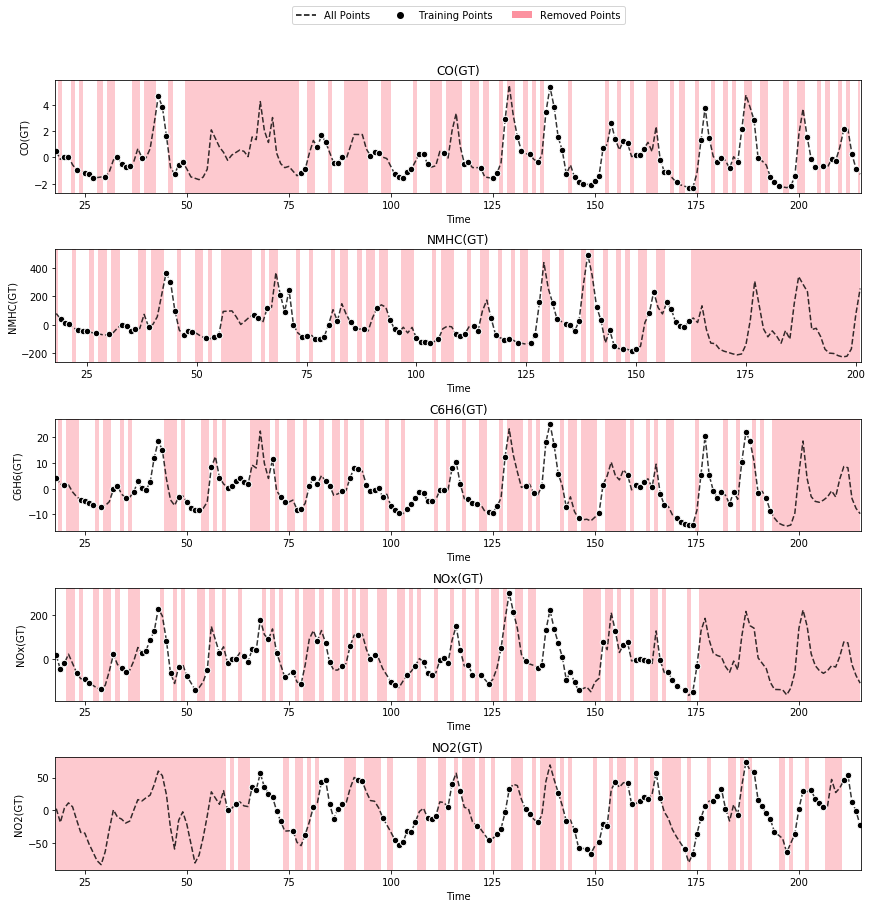

In [3]:
for channel in dataset:
    channel.remove_randomly(pct=0.4)

# drop relative ranges to simulate sensor failure
dataset[0].remove_relative_range(0.2, 0.3)
dataset[1].remove_relative_range(0.8, None)
dataset[2].remove_relative_range(0.9, None)
dataset[3].remove_relative_range(0.8, None)
dataset[4].remove_relative_range(None, 0.2)


for channel in dataset:
    channel.transform(mogptk.TransformDetrend(degree=1))

dataset.plot();

## Create model

Lets create a multioutput Gaussian Process with MOSM kernel and initialize the parameters with BNSE.

In [4]:
# create grid to evaluate models
n_points = 500
n_channels = len(dataset)
x_pred = [np.linspace(dataset[0].X.min(), dataset[0].X.max(), n_points)] * n_channels

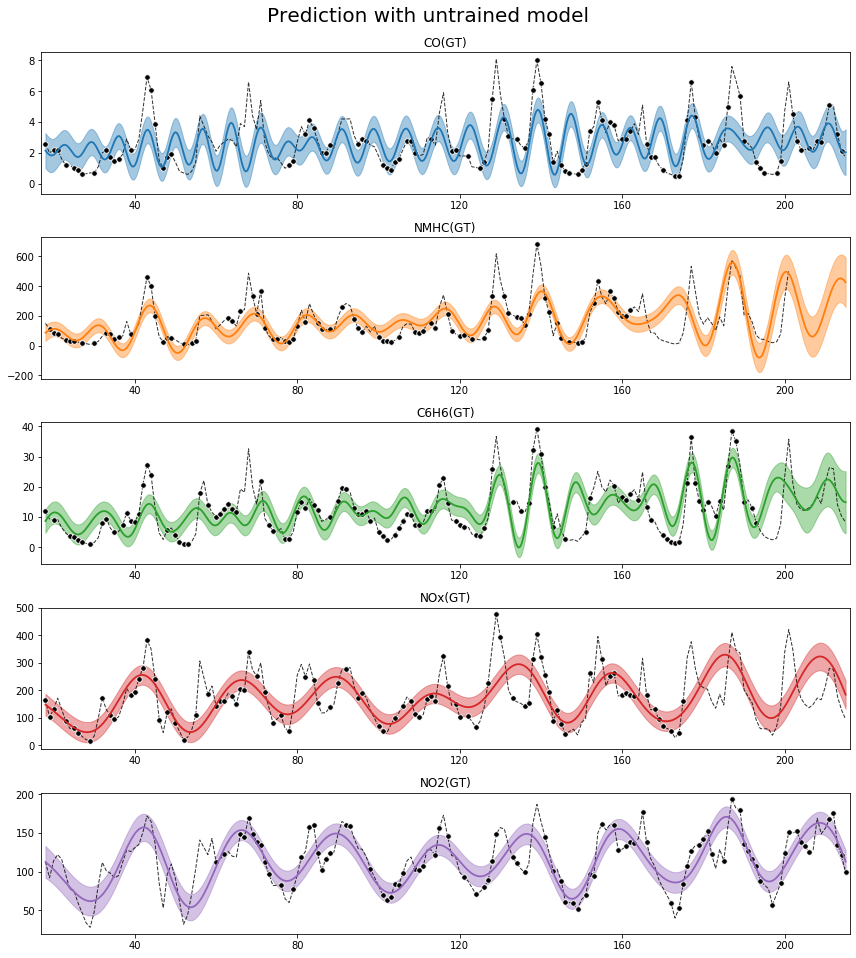

In [5]:
model = mogptk.MOSM(dataset, Q=3)
model.init_parameters('BNSE')

model.predict(x_pred)

model.plot_prediction(grid=(5, 1), title='Prediction with untrained model');

## Training Models


The main function to train models is [`mogptk.model.train`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.train).

We now train for a small number of iterations in order to get a preliminary estimation.

In [6]:
model.train(method='L-BFGS-B',
            tol=1e-6,
            maxiter=50,
            verbose=True)

Starting optimization
 >Model: MOSM
 >Channels: 5                    
 >Components: 3
 >Training points: 470
 >Parameters: 81
 >Initial NLL: 3838.172
Optimization finished in 1.31 minutes
 >Final NLL: 1711.491 



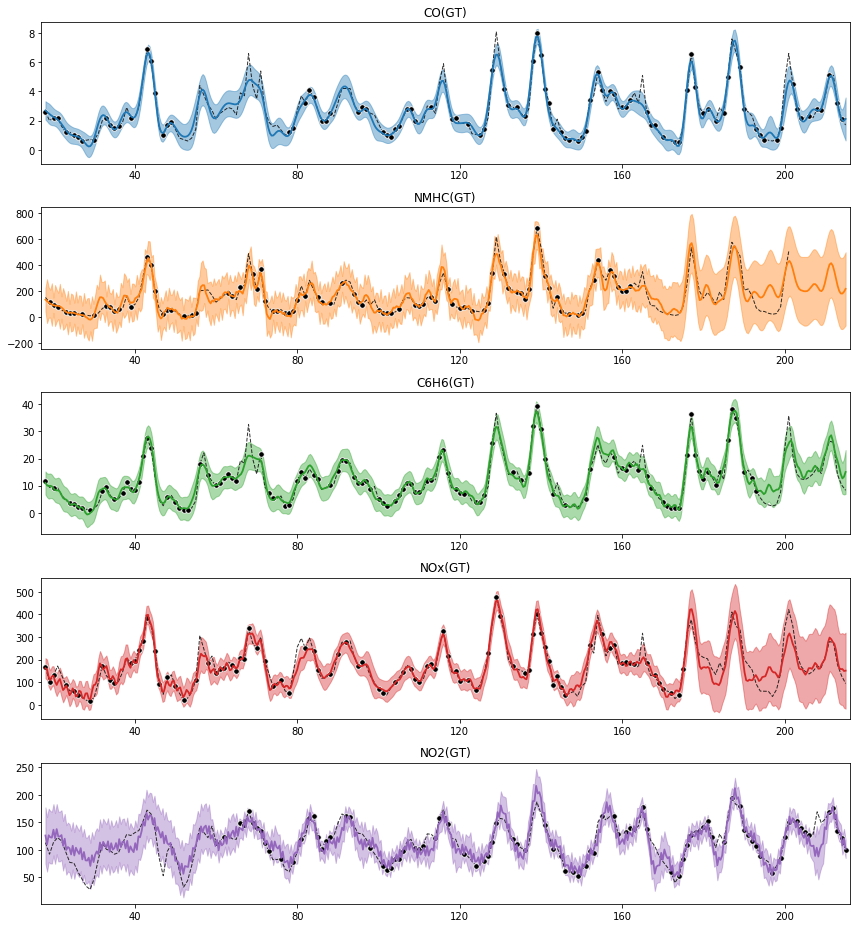

In [7]:
model.predict(x_pred)
model.plot_prediction(grid=(5, 1));

## Fixing parameters


We will now set the delay of the first component to 0 and fix them, not being modified in the optimization.
We will also fix the frequencies given the result is able to find fairly well the periodicities with a few iterations.

We can fix parameters with the [`mogptk.model.fix_parameter`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.fix_parameter) method, allowing to only optimize the remaining parameters

We can set values for the parameters with [`mogptk.model.set_parameter`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.set_paramter) and unfix parameters with [`mogptk.model.unfix_parameter`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.unfix_parameter)

In [8]:
model.set_parameter(0, 'delay', np.zeros(n_channels).reshape(1, -1))

model.fix_parameter(q=0, key='delay')
model.fix_parameter(model.Q, 'noise')
model.fix_parameter(np.arange(model.Q), 'mean')

Now we can print which parameters are fixed and which are not

In [9]:
model.print_parameters()

then we can train again, starting from the last parameters obtained, with some fixed values

In [10]:
model.train(method='L-BFGS-B',
            tol=1e-6,
            maxiter=50,
            verbose=True)

Starting optimization
 >Model: MOSM
 >Channels: 5                    
 >Components: 3
 >Training points: 470
 >Parameters: 56
 >Initial NLL: 1711.437
Optimization finished in 1.26 minutes
 >Final NLL: 1668.056 



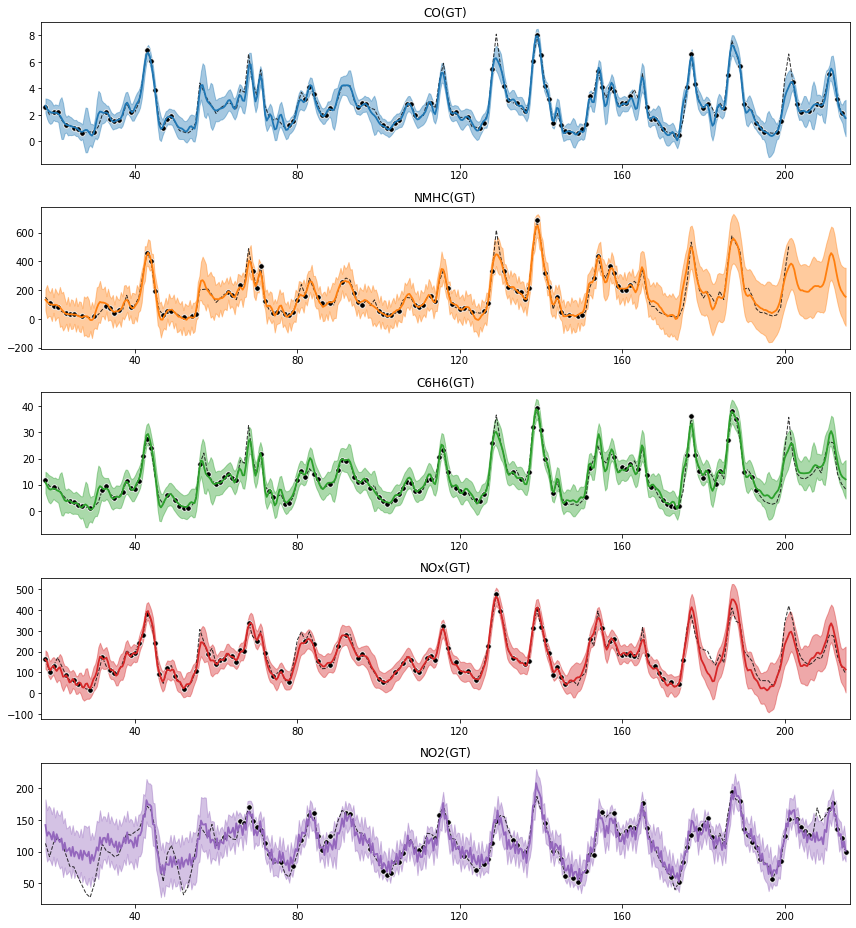

In [11]:
model.predict(x_pred)
model.plot_prediction(grid=(5, 1));

## Save the model to create checkpoints

In order to create checkpoints we can alternate bewteen calls to [`model.train`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.train) and [`model.save_parameters`](https://games-uchile.github.io/mogptk/model.html#mogptk.model.model.save_parameters)

In [12]:
model.unfix_parameter(model.Q, 'noise')
model.unfix_parameter(0, 'delay')

In [ ]:
n_saves = 4
it_per_save = 100

for i in range(n_saves):
    model.train(maxiter=it_per_save)
    model.save_parameters('air_quality_mosm_%d' % (i,))

In [ ]:
model.predict(x_pred)

model.plot_prediction(grid=(5, 1));